In [1]:
from langgraph.graph import StateGraph, START,END
from langchain_core.messages import BaseMessage,HumanMessage,ToolMessage,SystemMessage
from langchain_core.tools import tool
from langgraph.graph import add_messages
from langgraph.prebuilt import ToolNode
from typing import TypedDict,Annotated,Sequence

In [2]:
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
llm = ChatGroq(model="Gemma2-9b-It")


In [3]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]

In [4]:
@tool
def add(a,b):
    """ This is to add 2 numbers and returns their addition"""
    print("Tool was called")
    return a+b

def divide(a,b):
    """ This is to divide 2 numbers and returns their division result"""
    return a/b

from langchain_tavily import TavilySearch

tavilytool = TavilySearch(
    max_results=5,
    topic="general",
)

In [5]:
tools = [add,tavilytool,divide]

In [6]:
llm = ChatGroq(model="Gemma2-9b-It").bind_tools(tools)

In [7]:
def model_call(state:AgentState):
    system_prompt = SystemMessage(content="You are a helpful assistant, please answer my questions")
    response = llm.invoke([system_prompt] + state['messages'])
    return {"messages":[response]}

In [8]:
def should_continue(state:AgentState):
    messages = state['messages']
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    return "continue"

In [19]:
graph = StateGraph(AgentState)
graph.add_node("caller",model_call)
tool_node = ToolNode(tools=tools)
graph.add_node("Toolbox",tool_node)

graph.set_entry_point("caller")
graph.add_edge("Toolbox","caller")
graph.add_conditional_edges(
    "caller",
    should_continue,
    {
        "continue":"Toolbox",
        "end":END
    }
)
from langgraph.checkpoint.memory import MemorySaver
memo = MemorySaver()
build = graph.compile(interrupt_before=["caller"],checkpointer=memo)

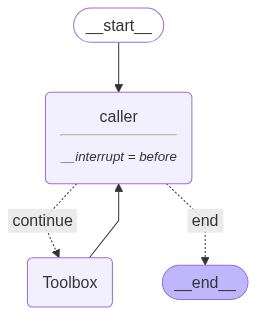

In [20]:
from IPython.display import display,Image
display(Image(build.get_graph().draw_mermaid_png()))

In [21]:
thread = {"configurable":{"thread_id":"12"}}

In [38]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Add 40 and  12. Also tell some latest cricket news, and also divide the previous result by 13")]}
print_stream(build.stream(inputs, stream_mode="values",config=thread))

================================ Human Message =================================

Add 40 and  12. Also tell some latest cricket news, and also divide the previous result by 13


In [39]:
build.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Add 40 and  12. Also tell some latest cricket news, and also divide the previous result by 13', additional_kwargs={}, response_metadata={}, id='629d95c5-9c7d-46a9-9da8-c0476c960e11'), HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='fa8c1a80-2391-4a83-9c49-32ef1890a144'), HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='a36d6bc4-2fb1-49aa-950a-34a5979196ba'), HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='3b787a48-5a4f-403d-b246-011f7b632084'), HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='f14689b3-aa7d-427f-9054-013e3b0b6442'), HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='65552b56-946e-4494-81ce-00f2064d2d4e'), HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='fdfdd04e-3349-40

In [26]:
s = build.get_state(thread)
s.next

('caller',)

In [40]:
build.get_state(thread).values

{'messages': [HumanMessage(content='Add 40 and  12. Also tell some latest cricket news, and also divide the previous result by 13', additional_kwargs={}, response_metadata={}, id='629d95c5-9c7d-46a9-9da8-c0476c960e11'),
  HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='fa8c1a80-2391-4a83-9c49-32ef1890a144'),
  HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='a36d6bc4-2fb1-49aa-950a-34a5979196ba'),
  HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='3b787a48-5a4f-403d-b246-011f7b632084'),
  HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='f14689b3-aa7d-427f-9054-013e3b0b6442'),
  HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='65552b56-946e-4494-81ce-00f2064d2d4e'),
  HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='fdfdd04e-3349-4067-8c46-6

#### Updating the state, (as part of human feedback)

In [42]:
## updating state

build.update_state(thread,{"messages":"No no, add 30 and 11."})
build.get_state(thread).values


{'messages': [HumanMessage(content='Add 40 and  12. Also tell some latest cricket news, and also divide the previous result by 13', additional_kwargs={}, response_metadata={}, id='629d95c5-9c7d-46a9-9da8-c0476c960e11'),
  HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='fa8c1a80-2391-4a83-9c49-32ef1890a144'),
  HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='a36d6bc4-2fb1-49aa-950a-34a5979196ba'),
  HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='3b787a48-5a4f-403d-b246-011f7b632084'),
  HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='f14689b3-aa7d-427f-9054-013e3b0b6442'),
  HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='65552b56-946e-4494-81ce-00f2064d2d4e'),
  HumanMessage(content='No no, add 30 and 11.', additional_kwargs={}, response_metadata={}, id='fdfdd04e-3349-4067-8c46-6

## To continue with the same prompt just pass no message and run again

### Agent Memory integration

In [43]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "")]}
print_stream(build.stream(None, stream_mode="values",config=thread))

================================ Human Message =================================

No no, add 30 and 11.
================================== Ai Message ==================================
Tool Calls:
  add (64em46274)
 Call ID: 64em46274
  Args:
    a: 30
    b: 11
Tool was called
================================= Tool Message =================================
Name: add

41


## Wrong now, so need to add memory

## Memory Saver - while compiling, enable it, we will have checkpoints, which will act as memory

In [82]:
graph = StateGraph(AgentState)
graph.add_node("caller",model_call)
tool_node = ToolNode(tools=tools)
graph.add_node("Toolbox",tool_node)

graph.set_entry_point("caller")
graph.add_edge("Toolbox","caller")
graph.add_conditional_edges(
    "caller",
    should_continue,
    {
        "continue":"Toolbox",
        "end":END
    }
)

###
from langgraph.checkpoint.memory import MemorySaver
memo = MemorySaver()
build = graph.compile(checkpointer=memo)

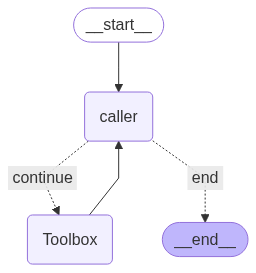

In [83]:
from IPython.display import display,Image
display(Image(build.get_graph().draw_mermaid_png()))

## Now that we have inMemory, provide a thread for invoking,
## Its unique for a user and so diff threads for diff users, and all of them have their context saved

In [84]:
config = {"configurable":{"thread_id":"1"}}
## pass config while invoking the graph!

inputs = {"messages": [("user", "Add 40 and  12. Also tell some latest cricket news, and also divide the previous result by 13")]}
messages = build.invoke(inputs, config=config)
for m in messages['messages']:
    m.pretty_print()


Tool was called
================================ Human Message =================================

Add 40 and  12. Also tell some latest cricket news, and also divide the previous result by 13
================================== Ai Message ==================================
Tool Calls:
  add (4s9a2gkrv)
 Call ID: 4s9a2gkrv
  Args:
    a: 40
    b: 12
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================
Tool Calls:
  divide (f6mmr6qqw)
 Call ID: f6mmr6qqw
  Args:
    a: 52
    b: 13
================================= Tool Message =================================
Name: divide

4.0
================================== Ai Message ==================================

According to Cricbuzz, India won the first ODI against Australia by 5 wickets!  Rohit Sharma scored a brilliant century for India.


In [85]:
inputs = {"messages": [("user", "now divide the previous result by 2")]}
messages = build.invoke(inputs, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 40 and  12. Also tell some latest cricket news, and also divide the previous result by 13
================================== Ai Message ==================================
Tool Calls:
  add (4s9a2gkrv)
 Call ID: 4s9a2gkrv
  Args:
    a: 40
    b: 12
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================
Tool Calls:
  divide (f6mmr6qqw)
 Call ID: f6mmr6qqw
  Args:
    a: 52
    b: 13
================================= Tool Message =================================
Name: divide

4.0
================================== Ai Message ==================================

According to Cricbuzz, India won the first ODI against Australia by 5 wickets!  Rohit Sharma scored a brilliant century for India.
================================ Human Message =================================

now divide the